## DBsimilarity - Basics in Chemometrics 

   Computational methods are essential in the field of natural products, particularly for the analysis of unfractionated extracts. Chemoinformatics can provide valuable data for specimen prioritization, biological hypothesis generation, biosynthesis studies, taxonomical studies, and in-silico bioactivity investigations. 
    
   To improve the complex and costly process of drug discovery from natural products, this paper proposes a method that involves (1) converting .sdf files into .csv files, (2) organizing the data into a dataframe, (3) adding chemoinformatics data, (4) constructing a custom database for rapid dereplication of MS data, (5) constructing a candidate list of compounds for rapid dereplication of 2D NMR data, (6) calculating similarities between compounds, and (7) constructing Similarity Networks using Cytoscape. 
    
* The aim of this method is to enable researchers to better understand the information available from a list of compounds found in a specimen. This method does not require specific programming skills and values readability on Jupyter Notebooks to assist users in developing valuable programming skills.


#### Useful sources to learn:
* Pandas: https://pandas.pydata.org/
* RDKit: https://www.rdkit.org/docs/GettingStartedInPython.html
* Data professor (Chanin Nantasenamat, Ph.D.): https://www.youtube.com/c/DataProfessor
* Pandas from Data professor: https://www.youtube.com/watch?v=9m4n2xVzk9o



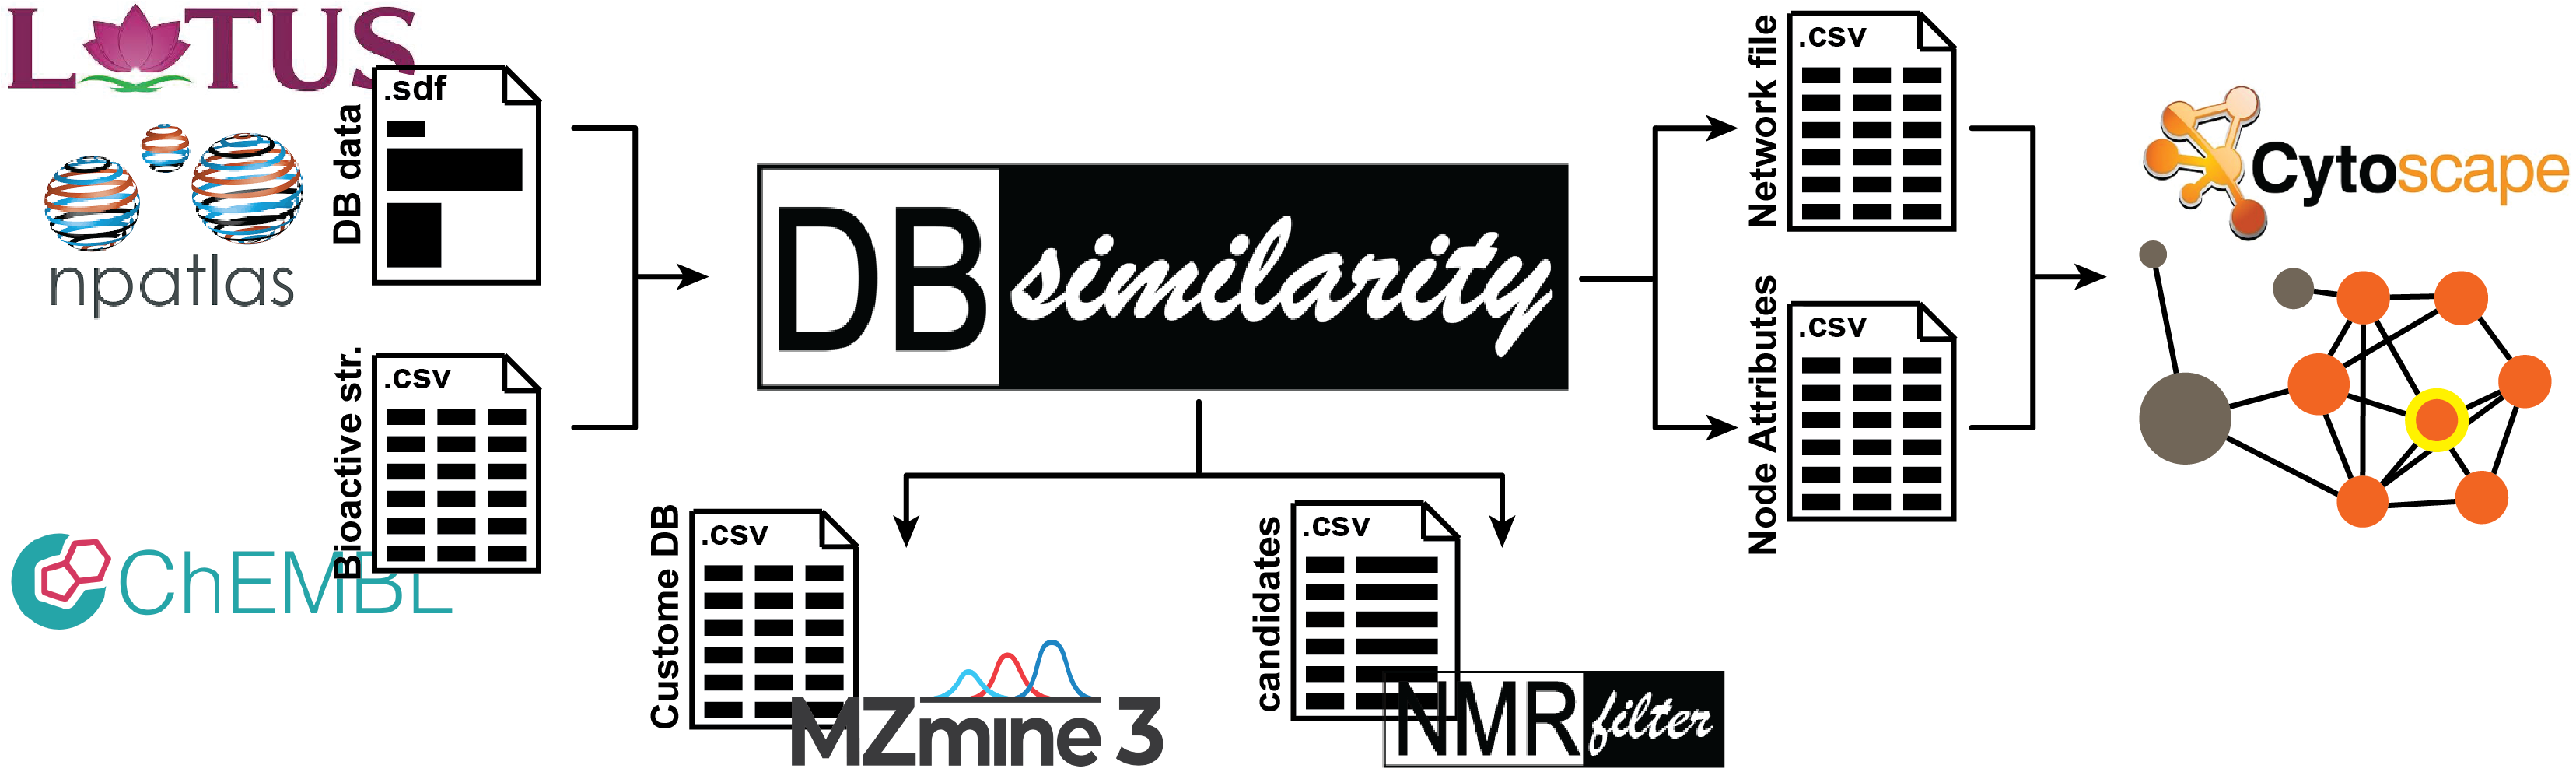

###### Import Required Dependencies

In [1]:
# rdkit (https://www.rdkit.org/docs/Install.html)
import rdkit 
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem import Descriptors

# mordred (http://mordred-descriptor.github.io/documentation/master/)
from mordred import Calculator, descriptors
from mordred import Chi, MoeType

import numpy
import pandas as pd
import seaborn as sns
import plotly
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
matplotlib.use('nbagg') # allow zoom 
%matplotlib inline
from matplotlib import gridspec
%matplotlib notebook

import glob
import os
orig_path = os.path.abspath(os.getcwd())

### Select the project which has the data

In [2]:
Project = 'NPAtlas+ChEMBL'
%cd $Project
wk_path = [orig_path + '/' + Project]

/home/nmrbox/rborges/Desktop/GitHub/Structure_Similarity_Chemoinformatics-main/NPAtlas+ChEMBL


In [ ]:
%ls

### Reading the input file with data (the database)

* When users already have their costume database with the smile structures (e.g. in-house database of compounds), they can read them directly

In [3]:
# Get the structures and data from the master worksheet
datafile_npatlas1 = pd.read_csv(glob.glob('NPAtlas*.csv')[0], sep="\t")
datafile_npatlas2 = datafile_npatlas1.loc[datafile_npatlas1['mibig_ids'].apply(lambda x: len(x) > 2)]
#datafile_npatlas2#.shape
# Create another datafile to use only the selected information (id and smiles)
datafile_npatlas = datafile_npatlas2.loc[:,["npaid","compound_smiles","compound_inchikey"]]
datafile_npatlas.rename(columns={"compound_inchikey":"Inchikey","compound_smiles":"SMILES"}, inplace=True)
#datafile_npatlas2['mibig_ids']#.head(2)
print('Size of this dataset came from ',datafile_npatlas2.shape,' to ', datafile_npatlas2.shape,'.')


Size of this dataset came from  (1609, 31)  to  (1609, 31) .


In [ ]:
# Get the structures and data from the master worksheet
datafile_chembl1 = pd.read_csv(glob.glob('ChEMBL*.csv')[0], sep=";")

# Create another datafile to use only the selected information (id and smiles)
datafile_chembl = datafile_chembl1.loc[:,["ChEMBL ID","Smiles","Inchi Key"]]
datafile_chembl.rename(columns={"Inchi Key":"Inchikey","Smiles":"SMILES"}, inplace=True)
datafile_chembl.head(2)

#### Combine different dataframes

In [ ]:
import pandas as pd

def merge_dataframes(df_list, key_column):
    # Merge the dataframes using pivot_table
    merged_df = pd.concat(df_list, axis=0, ignore_index=True)
    merged_df = merged_df.pivot_table(index=key_column, aggfunc='first').reset_index()

    # Create the additional columns
    for i, df in enumerate(df_list):
        col_name = f"additional_column_{i+1}"
        merged_df[col_name] = merged_df[key_column].isin(df[key_column]).astype(int)

    # Fill missing values with 0
    merged_df = merged_df.fillna(0)

    return merged_df


# Combine both dataframes
merged_df = merge_dataframes([datafile_npatlas,datafile_chembl], 'Inchikey')
print(merged_df.shape)
print(datafile_npatlas.shape)
print(datafile_chembl.shape)
print('Merged dataframes from ',datafile_npatlas.shape,' + ',datafile_chembl.shape)

##### Get the Classification for the Structures in the database
* Users might want to add NPClassifier or Classyfire information to their visualizations 
    * NPClassifier: the next cell constructs the required file that can be submitted to GNPS for the method NPCLASSIFIER for batch classification
    
    * Classifyre: for that, users must open the *_extended.csv file, copy the column InchiKey and past it at the web server Batch Compound Classification (https://cfb.fiehnlab.ucdavis.edu/)

In [ ]:
merged_df.head(1)

In [ ]:
# Constructing the .csv file to be submitted to NPClassifier
df_NPclassifier0 = merged_df[["Inchikey","SMILES"]]
df_NPclassifier0.to_csv(Project + '_for_NPClassifier.csv', index = False)

In [ ]:
# NPClassifier
df_NPclassifier = pd.read_csv(glob.glob('NPCLASSIFIER*.tsv')[0], sep="\t")
#datafile2 = pd.merge(datafile2, df_NPclassifier, on='SMILES')
#datafile2.to_csv(Project + '_with_NPClassifier.csv', index = False)
print(df_NPclassifier.shape)
print(merged_df.shape)
print(datafile_npatlas.shape)
print(datafile_chembl.shape)

##### Adding basic chemical information

* In this step, basic chemometric infromation will be added to the dataframe and saved as separate .csv file
    * Molecular Formula
    * Molecular Weight
    * Expected m/z values
    * INCHI code structures
    * INCHIKEY structures


In [ ]:
%%capture --no-display
mform = []
mw2 = []
mw_pH2 = []
mw_pNa2 = []
mw_pK2 = []
mw_nH2 = []
m11 = []

for mol in merged_df['SMILES']: # for-loop in every row to use the 'smiles' entrees 
    mform1 =  CalcMolFormula(Chem.MolFromSmiles(mol)) # calculate the exact molecular weigth 
    mform.append(mform1) # create a list of exact molecular weigth 
    
    mw = Descriptors.ExactMolWt(Chem.MolFromSmiles(mol)) # calculate the exact molecular weigth 
    mw2.append(mw) # create a list of exact molecular weigth 
      
    mw_nH = Descriptors.ExactMolWt(Chem.MolFromSmiles(mol)) - 1.007824 # calculate the exact molecular weigth 
    mw_nH2.append(mw_nH) # create a list of exact molecular weigth 
    
    mw_pH = Descriptors.ExactMolWt(Chem.MolFromSmiles(mol)) + 1.007824 # calculate the exact molecular weigth 
    mw_pH2.append(mw_pH) # create a list of exact molecular weigth 
    
    mw_pNa = Descriptors.ExactMolWt(Chem.MolFromSmiles(mol)) + 22.98977 # calculate the exact molecular weigth plus Na
    mw_pNa2.append(mw_pNa) # create a list of exact molecular weigth 
    
    mw_pK = Descriptors.ExactMolWt(Chem.MolFromSmiles(mol)) + 38.96370 # calculate the exact molecular weigth plus K
    mw_pK2.append(mw_pK) # create a list of exact molecular weigth 
    
    m1 = Chem.MolToInchi(Chem.MolFromSmiles(mol)) # produce the INCHI formula
    m11.append(m1) # create a list of INCHI formula
    
merged_df['MolFormula'] = mform      # include the newly created lists into the DataFrame
merged_df['Inchi'] = m11
merged_df['MolWeight'] = mw2
merged_df['MolWeight-1H'] = mw_nH2
merged_df['MolWeight+1H'] = mw_pH2
merged_df['MolWeight+Na'] = mw_pNa2
merged_df['MolWeight+K'] = mw_pK2

# save .CSV file with the datafile2 (extended version)
merged_df.to_csv(Project + '_extended.csv')
#merged_df.tail(2)

##### Running Similarities

In [ ]:
# create the column 'Molecules' with the structures for each SMILES entree at the column 'SMILES_parent'
datafile2 = merged_df
PandasTools.AddMoleculeColumnToFrame(datafile2,'SMILES','Molecule',includeFingerprints=True)
print([str(x) for x in  datafile2.columns])

# Grid visualization of the structures (one can see no more than 50 figures)
#PandasTools.FrameToGridImage(datafile2,column= 'Molecule', molsPerRow=5,subImgSize=(150,150),legendsCol="lotus_id") # visualization only

In [ ]:
# Produce a hashed Morgan fingerprint for each molecule
fplist = [] #fplist
datafile3 = datafile2

for mol in datafile2['Molecule']: # for-loop in every row to use the 'smiles' entrees 
    fp = Chem.GetMorganFingerprintAsBitVect(mol,2) # Returns a hashed Morgan fingerprint for a molecule
    fplist.append(fp) # create a list of the Morgan fingerprint

datafile3['mfp2'] = fplist

#datafile3.head(3) # visualization

##### Compare similarity between every pair of structures
    * this can take quite some time

In [ ]:
import time
start_time = time.time()

datafile4 = datafile3

# One can compare the similarity between every possible pairs of molecules in the list
# This takes time to run
for r in datafile4.index:
    fp1 = datafile4.at[r,'mfp2']
    colname = datafile4.at[r,'Inchikey']
    simlist = [] #fplist
    for mol in datafile4['Molecule']:
        fp = Chem.GetMorganFingerprintAsBitVect(mol,2)
        sim =DataStructs.DiceSimilarity(fp1,fp)
        simlist.append(sim)
    datafile4[colname]=simlist

# Removing fingerprint column and others to facilitate visualization
datafile4 = datafile4.drop(['mfp2','SMILES',"Inchi","MolWeight",
                            "MolWeight-1H", "MolWeight+1H", "MolWeight+Na", 
                            "MolWeight+K", "Molecule"], axis=1)
datafile4.head(3) # visualization

end_time = time.time()

duration = end_time - start_time
print("Duration: ", duration, "seconds")

#print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
Mol_ID_values = datafile4.loc[:,"Inchikey"]
Mol_ID_values # visualization

# The table of similarity. Note the diagonal (=1)
Mol_ID_values_list = Mol_ID_values.tolist()
simTable = datafile4[[*Mol_ID_values_list]] # simTable
simTable2 = simTable.iloc[:(len(Mol_ID_values_list))]
#simTable2.head(2)


In [ ]:
cm = sns.light_palette("red", as_cmap=True)
df_heatmap = datafile4.style.background_gradient(cmap=cm)
#df_heatmap

##### Calculate the correlation matrix and reshape into 3 columns

In [ ]:
# calculate the correlation matrix and reshape into 3 columns
simTable2_corr = simTable2.corr().stack().reset_index()

# rename the column headers
simTable2_corr.columns = ['FEATURE_1', 'FEATURE_2', 'CORRELATION']

# create a mask to identify rows with duplicate features
mask_dups = (simTable2_corr[['FEATURE_1', 'FEATURE_2']].apply(frozenset, axis=1).duplicated()) | (simTable2_corr['FEATURE_1']==simTable2_corr['FEATURE_2']) 

# apply the mask to clean the correlation dataframe
simTable2_corr2 = simTable2_corr[~mask_dups]
simTable2_corr2

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=simTable2_corr2.loc[ (simTable2_corr2['CORRELATION'] > 0.85) & (simTable2_corr2['FEATURE_1'] != simTable2_corr2['FEATURE_2']) ]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'FEATURE_1', 'FEATURE_2')
nx.from_pandas_edgelist(links_filtered, 'FEATURE_1', 'FEATURE_2')
links_filtered.head(3)

# Plot the network:
#nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

In [ ]:
# save .CSV file (3 columns file) with the network for e.g. Cytoscape
links_filtered.to_csv(Project + '_DB_compounds_Similarity_85.csv', sep=";", index=False)
print(f"Done! Now that we have saved the similarity table as a 'Source', 'Target', and 'Interaction' (3 column) table with {len(Mol_ID_values.index)} rows.")

##### Filter Compounds of interest (Results)

In [4]:
datafile_npatlas2[["npaid", "compound_names", "origin_type", "genus", 
                            "origin_species"]]

,npaid,compound_names,origin_type,genus,origin_species
2,NPA000003,A-503083 F,Bacterium,Streptomyces,sp. SANK 62799
12,NPA000013,Not named,Fungus,Pithomyces,sp.
79,NPA000082,Communesin E,Fungus,Penicillium,expansum Link MK-57
192,NPA000195,Salinipostin A,Bacterium,Salinispora,sp.
247,NPA000250,Ripostatin B,Bacterium,Sorangium,cellulosum strain So ce377
...,...,...,...,...,...
28429,NPA028623,Prezeamine,Bacterium,Serratia,plymuthica RVH1
28430,NPA028624,Prezeamine I,Bacterium,Serratia,plymuthica RVH1
28512,NPA028706,Microviridin K,Bacterium,Oscillatoria,agardhii
28809,NPA029003,Microtermolide A,Bacterium,Streptomyces,sp.


In [26]:
# create a dictionary of strings to filter on
filter_dict = {
    "virginiamycin S1", "validamycin A", "selvamicin", "rosamicin", "pikromycin", 
    "paromomycin", "niddamycin", "neomycin", "neomethymycin", "narbomycin", 
    "mycinamicin II", "methymycin", "megalomicin C2", "megalomicin C1", "megalomicin B",
    "megalomicin A", "MM 47761", "lividomycin A", "lankamycin", "hydroxystreptomycin", 
    "gentamicin", "fortimicin B", "fijimycin A", "erythromycin C", "erythromycin B", 
    "chalcomycin A", "cephamycin C", "cephalosporin C", "butirosin B", "butirosin A", 
    "beta-D-galactosylvalidoxylamine A", "balhimycin", "avoparcin beta", "avoparcin alpha", 
    "apramyc"
    }

# Filter the rows that have specific texts in the `compound_name` column
filtered_df = datafile_npatlas2[datafile_npatlas2['compound_names'].isin(filter_dict)]

# Drop the remaining rows
filtered_df = filtered_df.reset_index(drop=True)
filtered_df[["npaid", "compound_names", "origin_type", "genus", 
                            "origin_species"]]


,npaid,compound_names,origin_type,genus,origin_species
0,NPA024604,MM 47761,Bacterium,Amycolatopsis,orientalis NCIB 12608


<div>
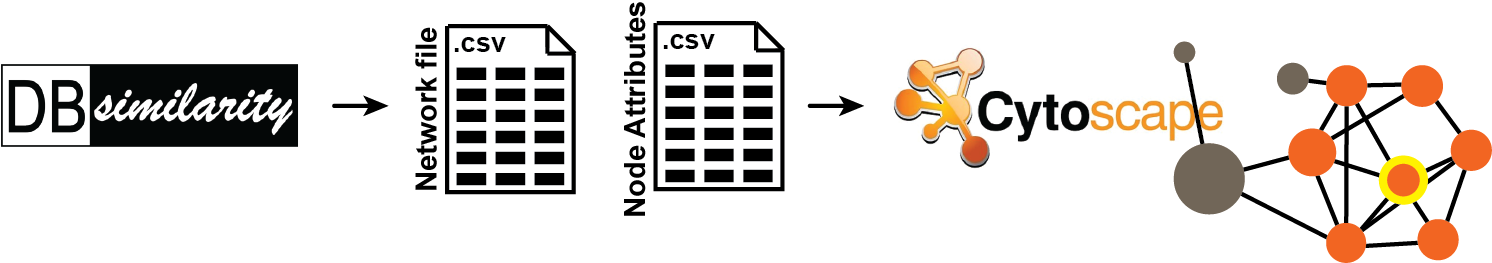
</div>

Thank you for using.

Feel free to contact us at ricardo_mborges@ufrj.br for doubts, ideas for next projects, or for collaborations. 

Check also:
* NMRfilter: Applying NMR compound identification using NMRfilter to match predicted to experimental data
    * https://link.springer.com/article/10.1007/s11306-020-01748-1
    

* DAFdiscovery: Data Fusion-based Discovery (DAFdiscovery) pipeline to aid compound annotation and bioactive compound discovery across diverse spectral data 
    * https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/abs/10.1002/pca.3178
